# Functions

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.tree import plot_tree

def plot_formatted_tree(
    decision_tree, 
    feature_names=None,
    class_names=None,
    samples_format="number",    # "percentage" or "number"
    value_format="percentage",  # "percentage" or "number"
    max_decimal_places=1,       # Maximum decimal places for formatting
    integer_thresholds=False,   # Whether to display thresholds as integers
    class_display="all",        # "all" or "one" - how to display class names
    figsize=(20, 10),
    filled=True,                # Whether to fill the nodes with color
    **kwargs  
):
    # Validate input parameters
    if value_format not in ["percentage", "number"]:
        raise ValueError("value_format must be 'percentage' or 'number'")
    if samples_format not in ["percentage", "number"]:
        raise ValueError("samples_format must be 'percentage' or 'number'")
    if class_display not in ["all", "one"]:
        raise ValueError("class_display must be 'all' or 'one'")
        
    # Create the figure and plot the tree
    fig, ax = plt.subplots(figsize=figsize)
    plot_tree(
        decision_tree,
        feature_names=feature_names,
        class_names=class_names,
        filled=filled, 
        **kwargs
    )
    
    # Get total training sample size
    # Total samples for samples_format="percentage"
    total_samples = int(decision_tree.tree_.n_node_samples[0])
    if total_samples <= 0:
        raise ValueError("Total samples must be greater than 0")

    # Find all the text boxes in the tree visualization
    for text in ax.texts:
        content = text.get_text()
        updated_content = content
        
        # Format samples field if present
        if 'samples = ' in content:
            samples_match = re.search(r'samples = (\d+)', content)
            if samples_match:
                node_samples = int(samples_match.group(1))
                
                # Format samples if needed
                if samples_format == "percentage" and total_samples > 0:
                    samples_percent = (node_samples / total_samples) * 100
                    if samples_percent == int(samples_percent):
                        samples_str = f"{int(samples_percent)}%"
                    else:
                        samples_str = f"{samples_percent:.{max_decimal_places}f}%"
                    updated_content = re.sub(
                        r'samples = \d+', 
                        f'samples = {samples_str}', 
                        updated_content
                    )
        
        # Format value field if present
        if 'value = [' in content:
                # Format values - fixed parsing to handle commas
                value_match = re.search(r'value = \[(.*?)\]', updated_content)
                if value_match:
                    value_str = value_match.group(1)
                    # Split by commas and remove any whitespace
                    values = [float(v.strip()) for v in value_str.split(',')]
                    
                    if value_format == "percentage":
                        formatted_values = []
                        for v in values:
                            pct = (v / node_samples) * 100
                            if pct == int(pct):
                                formatted_values.append(f"{int(pct)}%")
                            else:
                                formatted_values.append(f"{pct:.{max_decimal_places}f}%")
                        formatted_values_str = ", ".join(formatted_values)
                        updated_content = re.sub(
                            r'value = \[.*?\]', 
                            f'value = [{formatted_values_str}]',
                            updated_content
                        )

        # Format class - handle class display options
        if class_display == "all" and class_names is not None and len(class_names) > 0:
            # Check if this is a node (contains "class = " in the text)
            class_match = re.search(r'class = ([^\n]+)', updated_content)
            if class_match:
                class_str = class_names
                updated_content = re.sub(
                    r'class = ([^\n]+)', 
                    f'class = {class_str}',
                    updated_content
                )
                
        # Format threshold to integer if requested
        if integer_thresholds and ('<=' in content or '>' in content):
            threshold_match = re.search(r'([<=>]+) (\d+\.\d+)', content)
            if threshold_match:
                comparison = threshold_match.group(1)
                threshold = float(threshold_match.group(2))
                
                if comparison == "<=":
                    # For <= comparisons, floor the value
                    new_threshold = int(threshold)
                    if new_threshold < threshold:  # If we had to round down
                        updated_content = updated_content.replace(
                            f"{comparison} {threshold}", 
                            f"<= {new_threshold}"
                        )
                    else:  # Original was already an integer value
                        updated_content = updated_content.replace(
                            f"{threshold}", 
                            f"{new_threshold}"
                        )
                elif comparison == ">":
                    # For > comparisons, ceiling the value
                    new_threshold = int(np.ceil(threshold))
                    if new_threshold > threshold:  # If we had to round up
                        updated_content = updated_content.replace(
                            f"{comparison} {threshold}", 
                            f"> {new_threshold-1}"
                        )
                    else:  # Original was already an integer value
                        updated_content = updated_content.replace(
                            f"{threshold}", 
                            f"{new_threshold}"
                        )
        
        # Update the text if it changed
        if updated_content != content:
            text.set_text(updated_content)
    
    plt.tight_layout()
    return fig, ax



# Example

Total training samples: 112


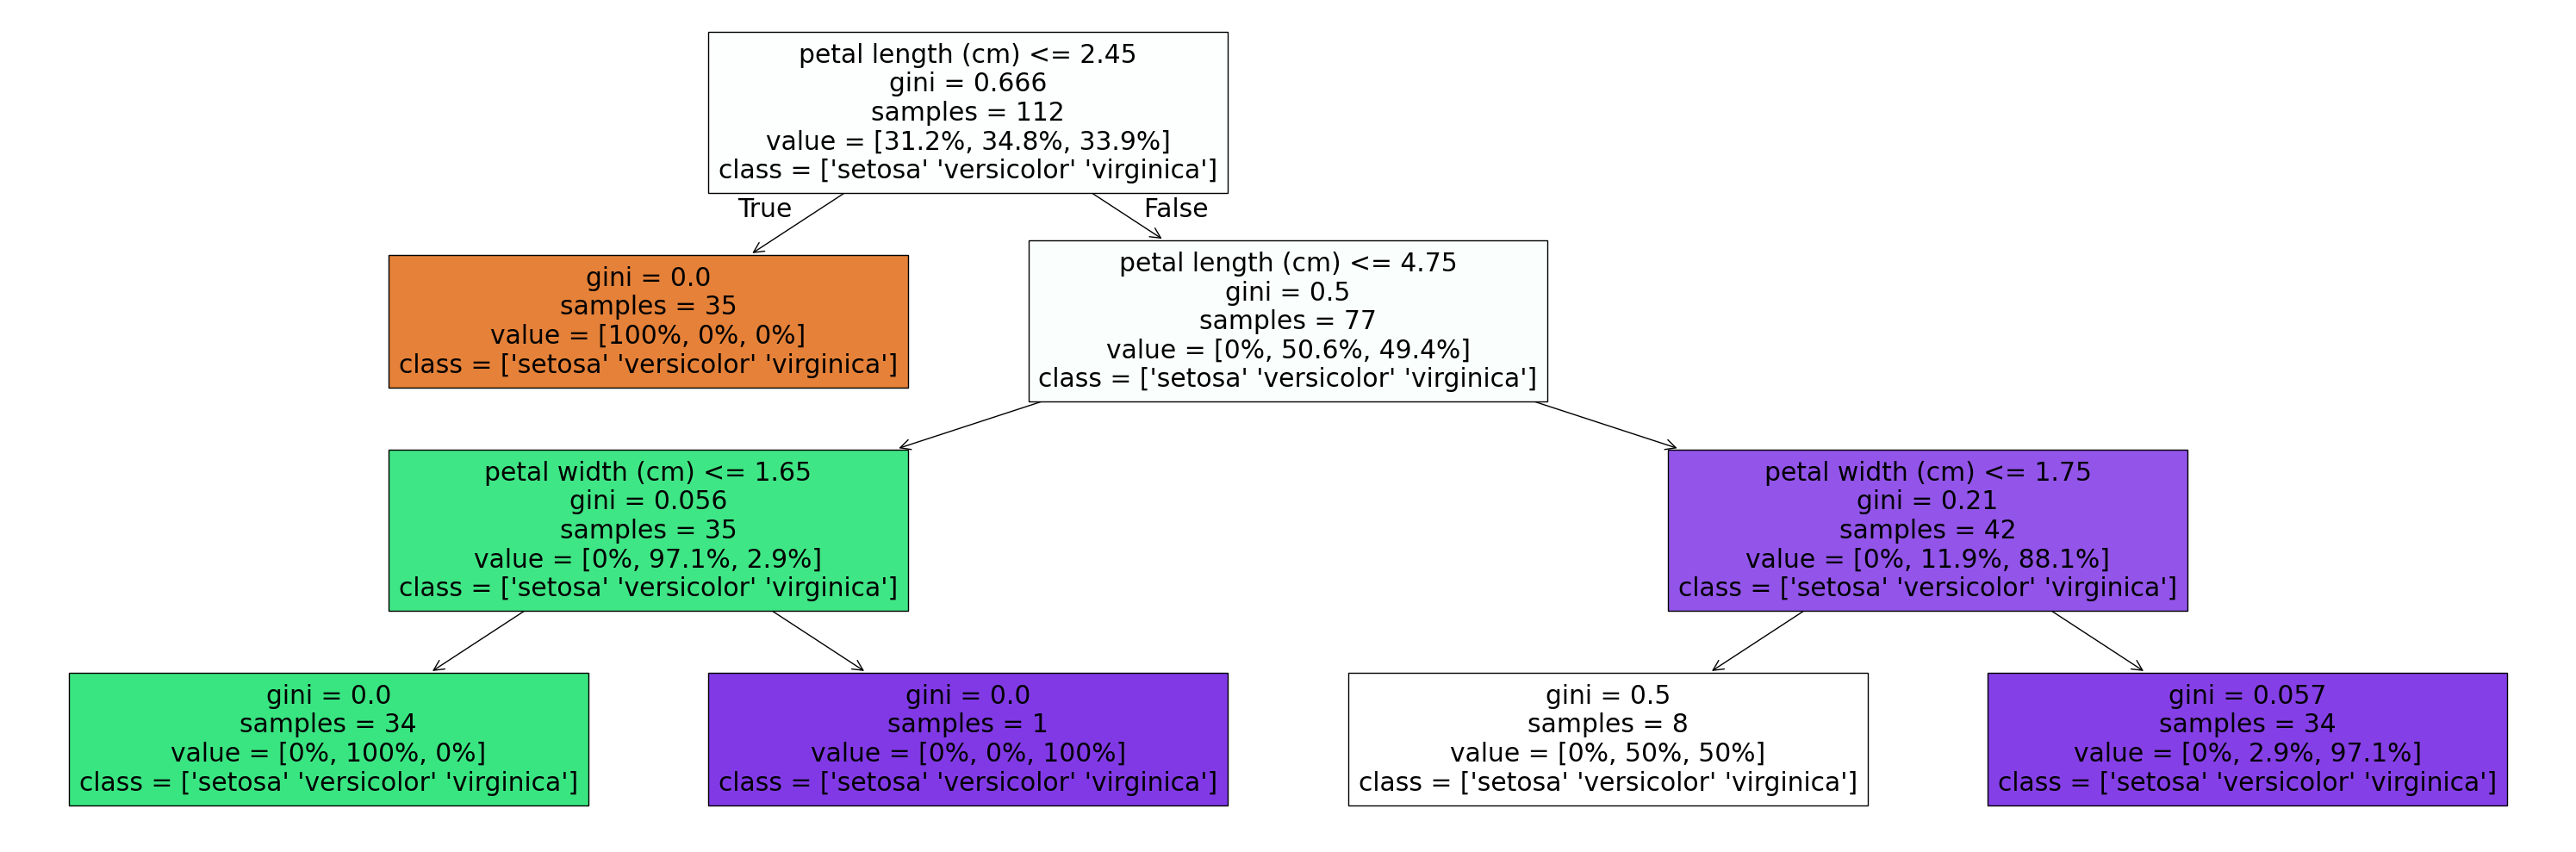

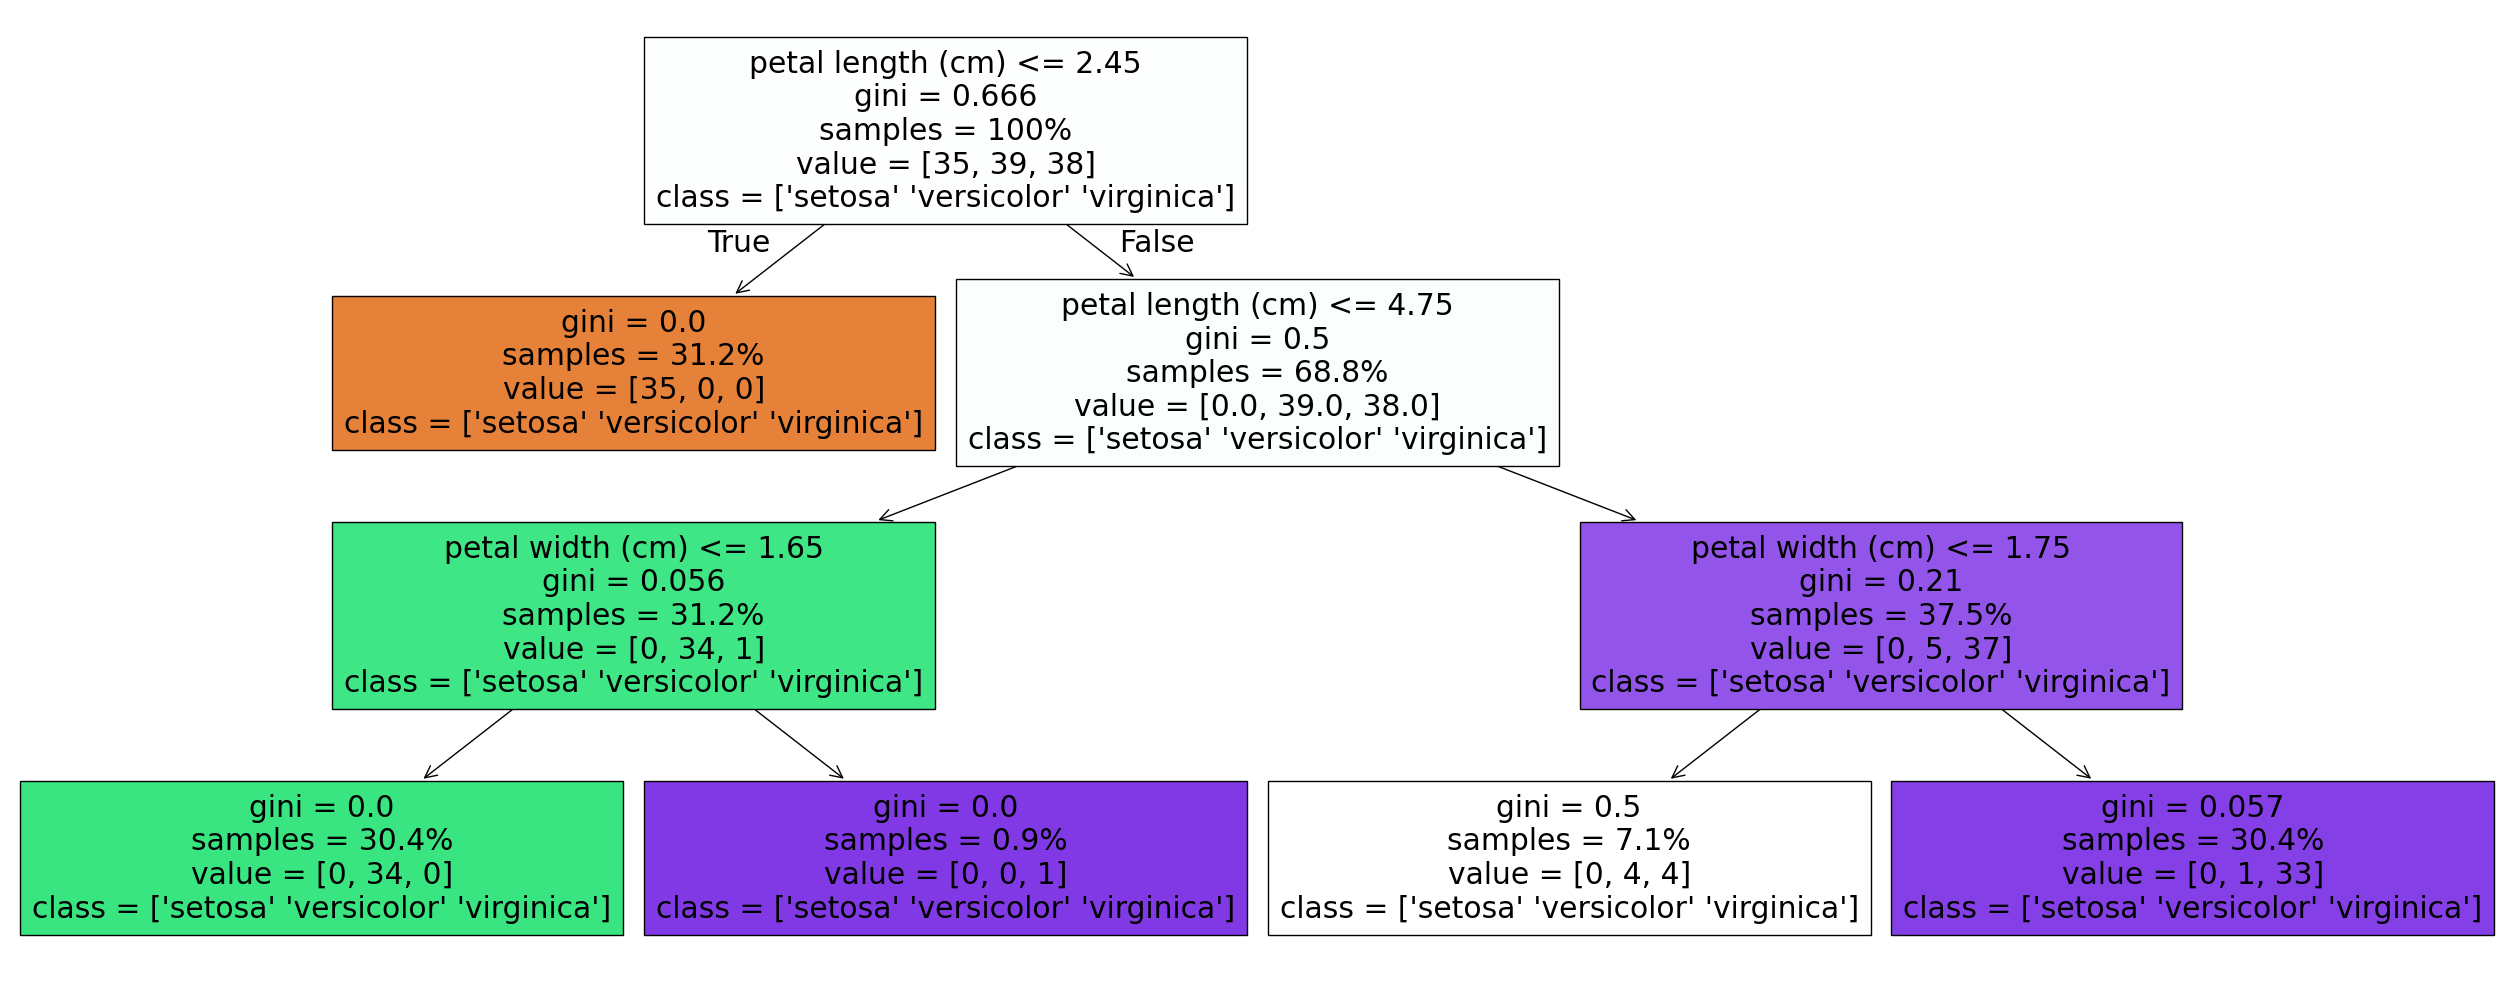

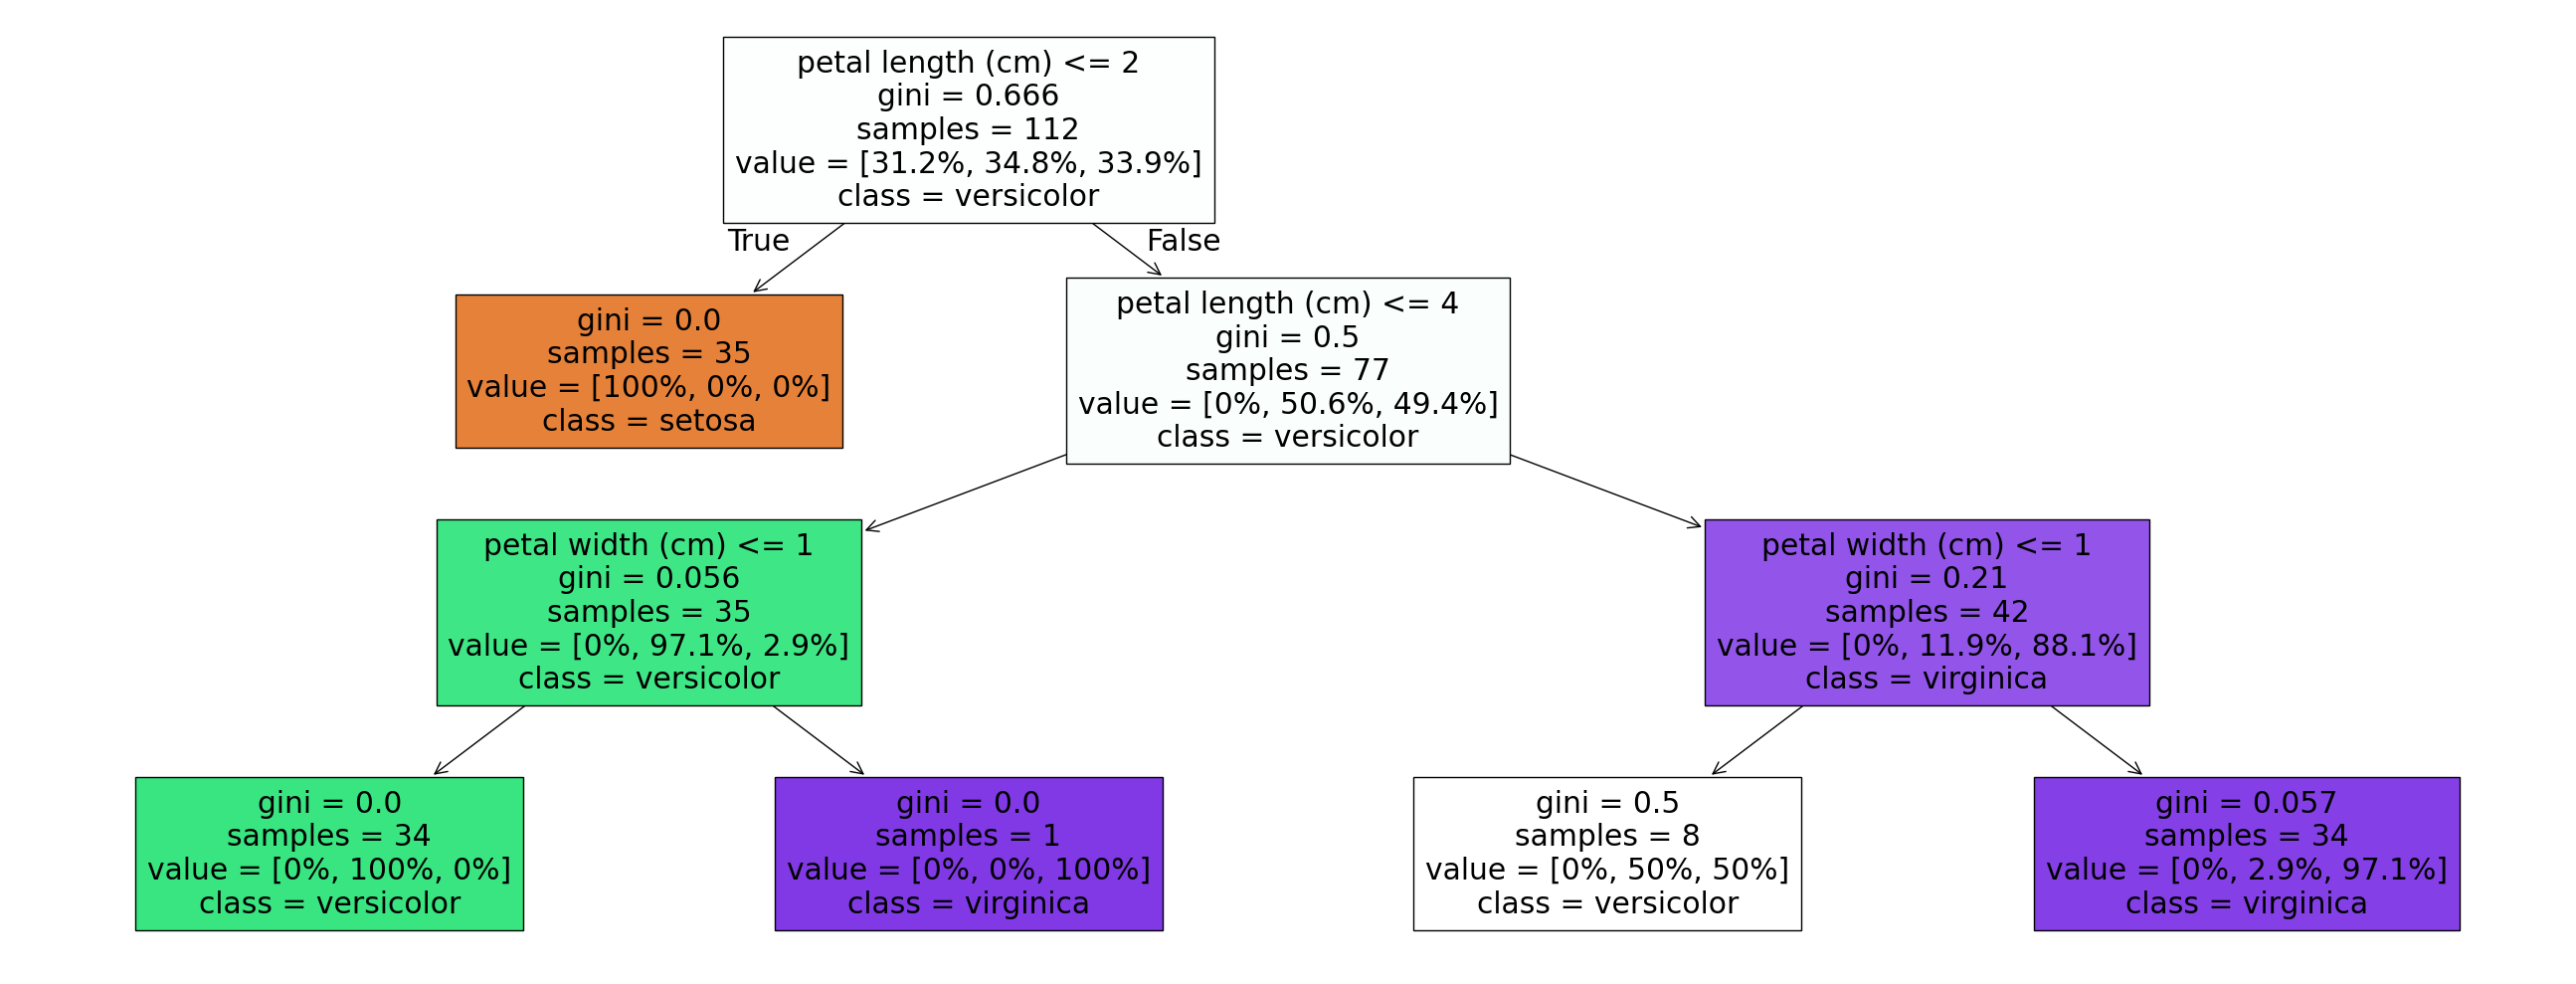

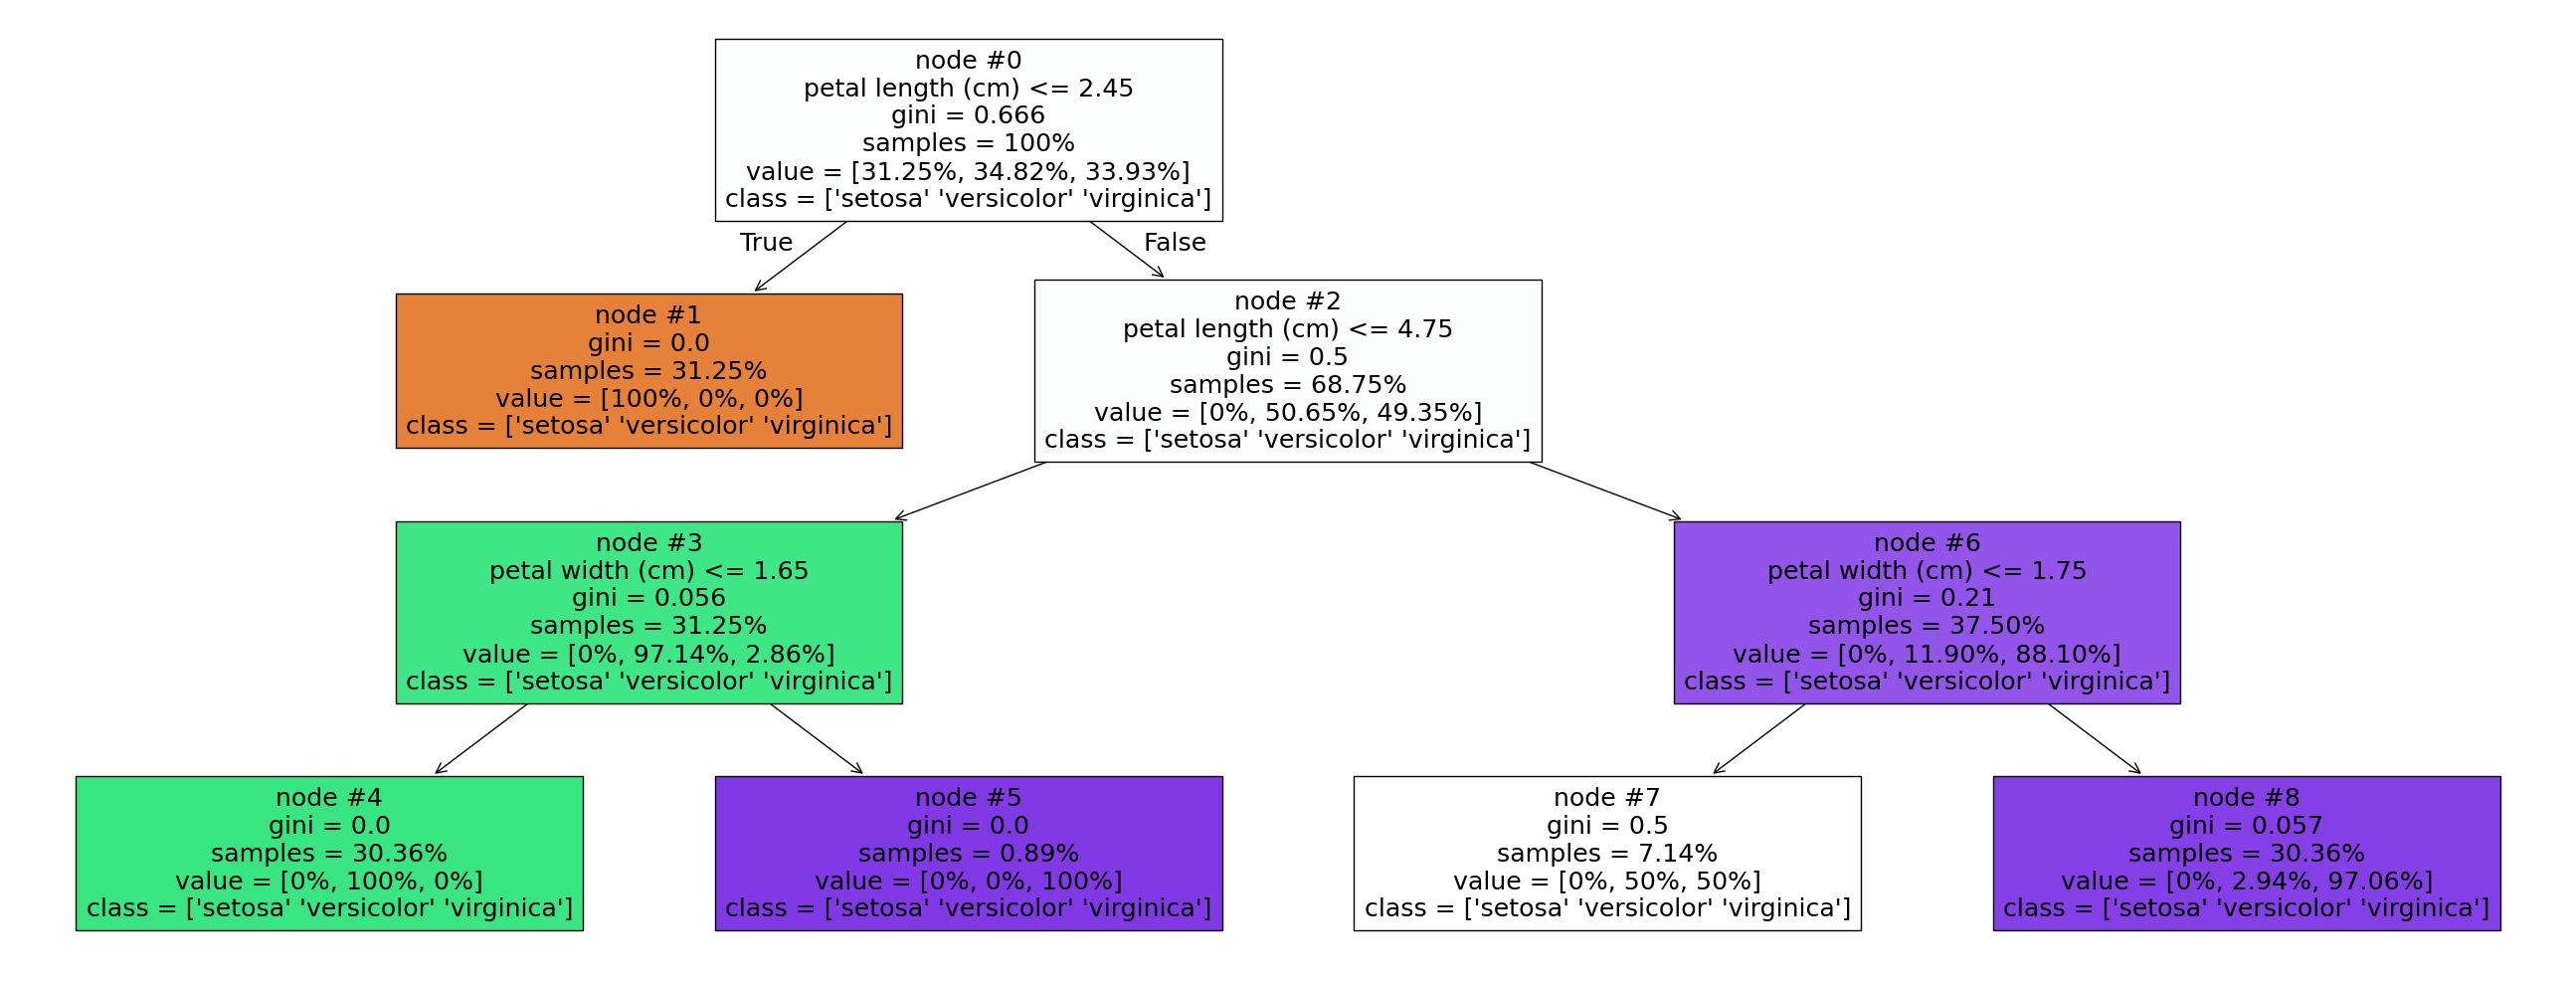

In [8]:
# Usage example
def example():
    from sklearn import datasets
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import train_test_split
    
    # Load dataset
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # Train a decision tree
    clf = DecisionTreeClassifier(max_depth=3, random_state=42)
    clf.fit(X_train, y_train)
    
    # Get total training sample size
    total_samples = int(clf.tree_.n_node_samples[0])
    print("Total training samples:", total_samples)
    
    # Example 1: Default - values as percentages, samples as numbers
    fig1, ax1 = plot_formatted_tree(
        clf,
        feature_names=iris.feature_names,
        class_names=iris.target_names,
        value_format="percentage",
        samples_format="number",
        figsize=(30, 10)
    )
    fig1.savefig('tree_default.png')
    
    # Example 2: Values as numbers, samples as percentages
    fig2, ax2 = plot_formatted_tree(
        clf,
        feature_names=iris.feature_names,
        class_names=iris.target_names,
        value_format="number",
        samples_format="percentage",
        figsize=(26, 10)
    )
    fig2.savefig('tree_samples_pct.png')
    
    # Example 3: Integer thresholds
    fig3, ax3 = plot_formatted_tree(
        clf,
        feature_names=iris.feature_names,
        class_names=iris.target_names,
        value_format="percentage",
        samples_format="number",
        integer_thresholds=True,
        class_display="one",
        figsize=(26, 10)
    )
    fig3.savefig('tree_integer_thresholds.png')
    
    # Example 4: All percentages with custom decimal places
    fig4, ax4 = plot_formatted_tree(
        clf,
        feature_names=iris.feature_names,
        class_names=iris.target_names,
        value_format="percentage",
        samples_format="percentage",
        max_decimal_places=2,  # Show 2 decimal places
        node_ids=True,  # Show node IDs
        figsize=(26, 10)
    )
    fig4.savefig('tree_all_pct.png')
    
    return clf

if __name__ == "__main__":
    example()